In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, conv1d, relu_,  relu, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
from sklearn.linear_model import LinearRegression

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [3]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [4]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [293]:
class GCN1D(object):
    def __init__(self,
                 numX=500,
                 inhibitionWindow=15,
                 inhibitionRadius=.5,                 
                 inhibitionStrength=50,
                 excitationWindow=5,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 placeAlpha=20,
                 activityMeanAlpha=.1,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactor=.9,
                 learnFactorP=.9,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 placeWeightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.directions = {"s": torch.tensor([1], device=device, dtype=torch.float),
                           "n": torch.tensor([-1], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1)*(2*excitationWindow+1),
                                                      numX,
                        device=device, dtype=torch.float)*initialWeightFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))

        
        self.numX = numX
        self.numPlaces=numPlaces
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
        
        
        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.inhibitoryWeights[:, i, :] = weight
                
        
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.longHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(0, boostGradientX, numX)
            decayGradient = np.linspace(0., decayGradientX, numX)
            tonicGradient = np.linspace(0., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(0., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(0., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(0., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient + boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient + boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient + globalTonic, device=device, dtype=torch.float)
        
        
        self.symmetrizer = torch.zeros((1+2*inhibitionWindow,
                                        1+2*inhibitionWindow),
                                       device=device,
                                       dtype=torch.float)
        
        self.symmetrizer[inhibitionWindow, inhibitionWindow] = 1.
        for i in range(1, inhibitionWindow+1):
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow-i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow-i] = 1/2.
        
        self.dt = dt
        self.decay = decayConstant
        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactor = negativeLearnFactor
        self.learnFactorP = learnFactorP
        self.weightDecay = weightDecay
        self.placeWeightDecay = placeWeightDecay
        self.normalize = normalize
        
        self.kernel = ((2*inhibitionWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, place=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.kernel).view(1, 1, self.numX)
        
        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        self.instantaneous += self.activationHistory * self.boostEffect
        self.instantaneous *= speed
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        self.activationHistory = self.alpha*self.dt*(-self.instantaneous) +\
                                 (1. - self.alpha*self.dt)*self.activationHistory
        self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.longHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self, time, logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
        self.placeActivity.fill_(0.)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                instOutput[s].copy_(self.instantaneous.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy(), instOutput.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity= torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory =torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.inhibitoryUpdate()
                self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayWeightsToNormalPattern()
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    
    def decayPlaceWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    
    def decayWeightsToNormalPattern(self):
        """
        Only decay place weights
        """
        self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights - self.originalWeights)/self.weightDecay
    
    
    def learn(self,
              runs,
              plotting=True,
              plotInterval=100,
              speed=1,
              offsets=(0,0),
              randomSpeed=False,
              logFreq=None,
              wrap=False):
        
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        # Space the starting points of the runs out.  This tends to improve the
        # translation-invariance of the weight profiles, and thus gives better
        # overall path integration.
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
            
        for run in range(runs):
            if randomSpeed:
                speed = (np.random.random() + 0.5)*speed
            
            if np.random.random() > 0.5:
                direction = 1
            else:
                direction = -1.

            length = 2*self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = (np.sin((runTimes * np.pi * direction / (self.envSize / speed) - np.pi / 2.)) + 1) * \
            self.envSize/2.
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
            
        
        if logFreq is not None:
            numSteps = int(time/self.dt)
            numLogs = int(numSteps/logFreq)
            output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            index = 0
        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                         dtype=torch.float)
            self.activationHistory.fill_(0.)
            self.simulate(100, logFreq=100000, startFrom=10000)
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = min(speed[i]/torch.mean(speed), 1.)
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                self.step(speed=s)
                self.stdpUpdate(i)
                #self.bcmPlaceUpdate()
                self.inhibitoryUpdate()
                self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayWeightsToNormalPattern()
                self.decayPlaceWeights()
                torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                torch.min(self.placeWeights, self.zero + 2., out=self.placeWeights)
#                 self.placeWeights *= .5/torch.mean(self.placeWeights, -1, keepdim=True)
                
                if logFreq is not None and i % logFreq == 0:
                    output[index].copy_(self.activity.view(self.numX))
                    index = index + 1
                    
                #self.decayWeights()
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()
            self.stdpUpdate(i, clearBuffer=True)
            
        return(output)

            
    def bcmPlaceUpdate(self):
        update = self.dt*self.learningRate*(torch.ger(self.instantaneous.view(self.numX),
                                                    self.placeActivity) -\
                                               torch.ger(self.longHistory.view(self.numX),
                                                    self.placeHistory)).view(self.numX, self.numPlaces)
        update = torch.transpose(update, 0, -1)
        update = update.view(self.numPlaces, 1, self.numX)
        update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
        update = update.view(self.numPlaces, self.numX)
        update = torch.transpose(update, 0, -1)
        self.placeWeights += update 
                             
            
    def stdpUpdate(self, time, clearBuffer=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                update = torch.ger(self.activity.view(self.numX), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                        self.learnFactorP
                update -= (torch.ger(self.activityBuffer[i], self.placeActivity) *\
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                      self.negativeLearnFactor *\
                                        self.learnFactorP
                
                update = torch.transpose(update, 0, -1)
                update = update.view(self.numPlaces, 1, self.numX)
                update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
                update = update.view(self.numPlaces, self.numX)
                update = torch.transpose(update, 0, -1)
                self.placeWeights += update 

            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            

        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    update = torch.ger(self.activityBuffer[j], self.placeBuffer[i]* \
                                            self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                            self.learnFactorP
                    update -= (torch.ger(self.activityBuffer[i], self.placeBuffer[j]) *\
                                            self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                          self.negativeLearnFactor *\
                                            self.learnFactorP
                    
                    update = torch.transpose(update, 0, -1)
                    update = update.view(self.numPlaces, 1, self.numX)
                    update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
                    update = update.view(self.numPlaces, self.numX)
                    update = torch.transpose(update, 0, -1)
                    self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
     

    def inhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.kernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.longHistory).view(1, 1, self.numX, 1),
                                  self.kernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/ \
                                     (self.longHistory**2 + 0.001)).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 5.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        


<IPython.core.display.Javascript object>


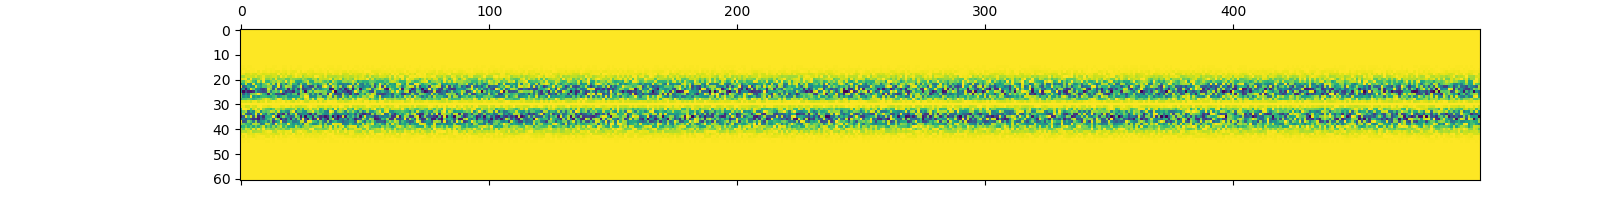

<IPython.core.display.Javascript object>


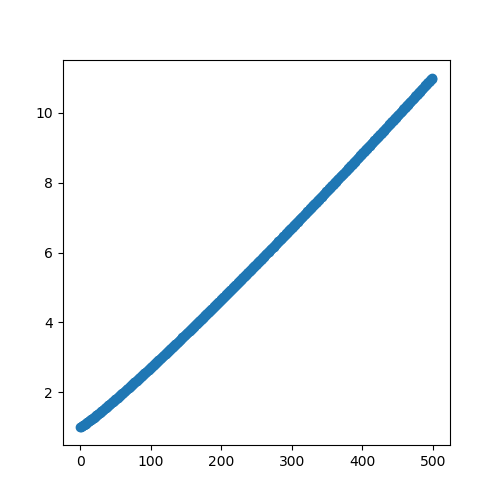

In [295]:
plt.rcParams['figure.figsize'] = [5, 5]

hatGCN = GCN1D(500,
            10,
            20.,
            5.,
            globalTonic=.025,
            tonicGradientX=0,
            stdpWindow=1,
            dt=0.01,
            boostEffect=.5,
            boostDecay=1.,
            placeAlpha=100.,
            decayConstant=.5,
            numPlaces=500,
            learningRate=100.,
            initialWeightFactor=.02,
            boostGradientX=19.5,
            decayGradientX=0.,
            weightDecay=500,
            wideningFactor=2,
            negativeLearnFactor=.9,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.0005,
            gradientType="exponential",
            envSize=5.,
            weightFunction=mexican_hat,
            normalize=True,
            weightNoise=2.)


inhibGCN = GCN1D(500,
            30,
            .5,
            300.,
            excitationWindow=5.,
            globalTonic=1.,
            tonicGradientX=10.,
            stdpWindow=1,
            dt=0.05,
            boostEffect=1.,
            boostDecay=.1,
            activityMeanAlpha=.01,
            placeAlpha=0.01,
            decayConstant=.3,
            numPlaces=500,
            learningRate=.001,
            initialWeightFactor=.02,
            boostGradientX=40.,
            decayGradientX=.2,
            weightDecay=500,
            placeWeightDecay=30,
            wideningFactor=0.,
            negativeLearnFactor=.9,
            learnFactorP=1000.,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.01,
            gradientType=1.1,
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)
plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN.globalTonic.shape[0]), inhibGCN.globalTonic) 
plt.show()


At 0.0
At 0.05
At 0.1
At 0.15000000000000002
At 0.2
At 0.25
At 0.30000000000000004
At 0.35000000000000003
At 0.4
At 0.45
At 0.5
At 0.55
At 0.6000000000000001
At 0.65
At 0.7000000000000001
At 0.75
At 0.8
At 0.8500000000000001
At 0.9
At 0.9500000000000001
At 1.0
At 1.05
At 1.1
At 1.1500000000000001
At 1.2000000000000002
At 1.25
At 1.3
At 1.35
At 1.4000000000000001
At 1.4500000000000002
At 1.5
At 1.55
At 1.6
At 1.6500000000000001
At 1.7000000000000002
At 1.75
At 1.8
At 1.85
At 1.9000000000000001
At 1.9500000000000002
At 2.0
At 2.0500000000000003
At 2.1
At 2.15
At 2.2
At 2.25
At 2.3000000000000003
At 2.35
At 2.4000000000000004
At 2.45
At 2.5
At 2.5500000000000003
At 2.6
At 2.6500000000000004
At 2.7
At 2.75
At 2.8000000000000003
At 2.85
At 2.9000000000000004
At 2.95
At 3.0
At 3.0500000000000003
At 3.1
At 3.1500000000000004
At 3.2
At 3.25
At 3.3000000000000003
At 3.35
At 3.4000000000000004
At 3.45
At 3.5
At 3.5500000000000003
At 3.6
At 3.6500000000000004
At 3.7
At 3.75
At 3.8000000000000003


At 33.15
At 33.2
At 33.25
At 33.300000000000004
At 33.35
At 33.4
At 33.45
At 33.5
At 33.550000000000004
At 33.6
At 33.65
At 33.7
At 33.75
At 33.800000000000004
At 33.85
At 33.9
At 33.95
At 34.0
At 34.050000000000004
At 34.1
At 34.15
At 34.2
At 34.25
At 34.300000000000004
At 34.35
At 34.4
At 34.45
At 34.5
At 34.550000000000004
At 34.6
At 34.65
At 34.7
At 34.75
At 34.800000000000004
At 34.85
At 34.9
At 34.95
At 35.0
At 35.050000000000004
At 35.1
At 35.15
At 35.2
At 35.25
At 35.300000000000004
At 35.35
At 35.4
At 35.45
At 35.5
At 35.550000000000004
At 35.6
At 35.65
At 35.7
At 35.75
At 35.800000000000004
At 35.85
At 35.9
At 35.95
At 36.0
At 36.050000000000004
At 36.1
At 36.15
At 36.2
At 36.25
At 36.300000000000004
At 36.35
At 36.4
At 36.45
At 36.5
At 36.550000000000004
At 36.6
At 36.65
At 36.7
At 36.75
At 36.800000000000004
At 36.85
At 36.9
At 36.95
At 37.0
At 37.050000000000004
At 37.1
At 37.15
At 37.2
At 37.25
At 37.300000000000004
At 37.35
At 37.4
At 37.45
At 37.5
At 37.550000000000004


At 67.4
At 67.45
At 67.5
At 67.55
At 67.60000000000001
At 67.65
At 67.7
At 67.75
At 67.8
At 67.85000000000001
At 67.9
At 67.95
At 68.0
At 68.05
At 68.10000000000001
At 68.15
At 68.2
At 68.25
At 68.3
At 68.35000000000001
At 68.4
At 68.45
At 68.5
At 68.55
At 68.60000000000001
At 68.65
At 68.7
At 68.75
At 68.8
At 68.85000000000001
At 68.9
At 68.95
At 69.0
At 69.05
At 69.10000000000001
At 69.15
At 69.2
At 69.25
At 69.3
At 69.35000000000001
At 69.4
At 69.45
At 69.5
At 69.55
At 69.60000000000001
At 69.65
At 69.7
At 69.75
At 69.8
At 69.85000000000001
At 69.9
At 69.95
At 70.0
At 70.05
At 70.10000000000001
At 70.15
At 70.2
At 70.25
At 70.3
At 70.35000000000001
At 70.4
At 70.45
At 70.5
At 70.55
At 70.60000000000001
At 70.65
At 70.7
At 70.75
At 70.8
At 70.85000000000001
At 70.9
At 70.95
At 71.0
At 71.05
At 71.10000000000001
At 71.15
At 71.2
At 71.25
At 71.3
At 71.35000000000001
At 71.4
At 71.45
At 71.5
At 71.55
At 71.60000000000001
At 71.65
At 71.7
At 71.75
At 71.8
At 71.85000000000001
At 71.9
At

At 99.55000000000001
At 99.60000000000001
At 99.65
At 99.7
At 99.75
At 99.80000000000001
At 99.85000000000001
At 99.9
At 99.95
At 100.0
At 100.05000000000001
At 100.10000000000001
At 100.15
At 100.2
At 100.25
At 100.30000000000001
At 100.35000000000001
At 100.4
At 100.45
At 100.5
At 100.55000000000001
At 100.60000000000001
At 100.65
At 100.7
At 100.75
At 100.80000000000001
At 100.85000000000001
At 100.9
At 100.95
At 101.0
At 101.05000000000001
At 101.10000000000001
At 101.15
At 101.2
At 101.25
At 101.30000000000001
At 101.35000000000001
At 101.4
At 101.45
At 101.5
At 101.55000000000001
At 101.60000000000001
At 101.65
At 101.7
At 101.75
At 101.80000000000001
At 101.85000000000001
At 101.9
At 101.95
At 102.0
At 102.05000000000001
At 102.10000000000001
At 102.15
At 102.2
At 102.25
At 102.30000000000001
At 102.35000000000001
At 102.4
At 102.45
At 102.5
At 102.55000000000001
At 102.60000000000001
At 102.65
At 102.7
At 102.75
At 102.80000000000001
At 102.85000000000001
At 102.9
At 102.95
At 

At 127.85000000000001
At 127.9
At 127.95
At 128.0
At 128.05
At 128.1
At 128.15
At 128.20000000000002
At 128.25
At 128.3
At 128.35
At 128.4
At 128.45000000000002
At 128.5
At 128.55
At 128.6
At 128.65
At 128.70000000000002
At 128.75
At 128.8
At 128.85
At 128.9
At 128.95000000000002
At 129.0
At 129.05
At 129.1
At 129.15
At 129.20000000000002
At 129.25
At 129.3
At 129.35
At 129.4
At 129.45000000000002
At 129.5
At 129.55
At 129.6
At 129.65
At 129.70000000000002
At 129.75
At 129.8
At 129.85
At 129.9
At 129.95000000000002
At 130.0
At 130.05
At 130.1
At 130.15
At 130.20000000000002
At 130.25
At 130.3
At 130.35
At 130.4
At 130.45000000000002
At 130.5
At 130.55
At 130.6
At 130.65
At 130.70000000000002
At 130.75
At 130.8
At 130.85
At 130.9
At 130.95000000000002
At 131.0
At 131.05
At 131.1
At 131.15
At 131.20000000000002
At 131.25
At 131.3
At 131.35
At 131.4
At 131.45000000000002
At 131.5
At 131.55
At 131.6
At 131.65
At 131.70000000000002
At 131.75
At 131.8
At 131.85
At 131.9
At 131.95000000000002

At 163.9
At 163.95000000000002
At 164.0
At 164.05
At 164.10000000000002
At 164.15
At 164.20000000000002
At 164.25
At 164.3
At 164.35000000000002
At 164.4
At 164.45000000000002
At 164.5
At 164.55
At 164.60000000000002
At 164.65
At 164.70000000000002
At 164.75
At 164.8
At 164.85000000000002
At 164.9
At 164.95000000000002
At 165.0
At 165.05
At 165.10000000000002
At 165.15
At 165.20000000000002
At 165.25
At 165.3
At 165.35000000000002
At 165.4
At 165.45000000000002
At 165.5
At 165.55
At 165.60000000000002
At 165.65
At 165.70000000000002
At 165.75
At 165.8
At 165.85000000000002
At 165.9
At 165.95000000000002
At 166.0
At 166.05
At 166.10000000000002
At 166.15
At 166.20000000000002
At 166.25
At 166.3
At 166.35000000000002
At 166.4
At 166.45000000000002
At 166.5
At 166.55
At 166.60000000000002
At 166.65
At 166.70000000000002
At 166.75
At 166.8
At 166.85000000000002
At 166.9
At 166.95000000000002
At 167.0
At 167.05
At 167.10000000000002
At 167.15
At 167.20000000000002
At 167.25
At 167.3
At 167.

At 194.05
At 194.10000000000002
At 194.15
At 194.20000000000002
At 194.25
At 194.3
At 194.35000000000002
At 194.4
At 194.45000000000002
At 194.5
At 194.55
At 194.60000000000002
At 194.65
At 194.70000000000002
At 194.75
At 194.8
At 194.85000000000002
At 194.9
At 194.95000000000002
At 195.0
At 195.05
At 195.10000000000002
At 195.15
At 195.20000000000002
At 195.25
At 195.3
At 195.35000000000002
At 195.4
At 195.45000000000002
At 195.5
At 195.55
At 195.60000000000002
At 195.65
At 195.70000000000002
At 195.75
At 195.8
At 195.85000000000002
At 195.9
At 195.95000000000002
At 196.0
At 196.05
At 196.10000000000002
At 196.15
At 196.20000000000002
At 196.25
At 196.3
At 196.35000000000002
At 196.4
At 196.45000000000002
At 196.5
At 196.55
At 196.60000000000002
At 196.65
At 196.70000000000002
At 196.75
At 196.8
At 196.85000000000002
At 196.9
At 196.95000000000002
At 197.0
At 197.05
At 197.10000000000002
At 197.15
At 197.20000000000002
At 197.25
At 197.3
At 197.35000000000002
At 197.4
At 197.450000000

At 224.4
At 224.45000000000002
At 224.5
At 224.55
At 224.60000000000002
At 224.65
At 224.70000000000002
At 224.75
At 224.8
At 224.85000000000002
At 224.9
At 224.95000000000002
At 225.0
At 225.05
At 225.10000000000002
At 225.15
At 225.20000000000002
At 225.25
At 225.3
At 225.35000000000002
At 225.4
At 225.45000000000002
At 225.5
At 225.55
At 225.60000000000002
At 225.65
At 225.70000000000002
At 225.75
At 225.8
At 225.85000000000002
At 225.9
At 225.95000000000002
At 226.0
At 226.05
At 226.10000000000002
At 226.15
At 226.20000000000002
At 226.25
At 226.3
At 226.35000000000002
At 226.4
At 226.45000000000002
At 226.5
At 226.55
At 226.60000000000002
At 226.65
At 226.70000000000002
At 226.75
At 226.8
At 226.85000000000002
At 226.9
At 226.95000000000002
At 227.0
At 227.05
At 227.10000000000002
At 227.15
At 227.20000000000002
At 227.25
At 227.3
At 227.35000000000002
At 227.4
At 227.45000000000002
At 227.5
At 227.55
At 227.60000000000002
At 227.65
At 227.70000000000002
At 227.75
At 227.8
At 227.

At 252.8
At 252.85000000000002
At 252.9
At 252.95000000000002
At 253.0
At 253.05
At 253.10000000000002
At 253.15
At 253.20000000000002
At 253.25
At 253.3
At 253.35000000000002
At 253.4
At 253.45000000000002
At 253.5
At 253.55
At 253.60000000000002
At 253.65
At 253.70000000000002
At 253.75
At 253.8
At 253.85000000000002
At 253.9
At 253.95000000000002
At 254.0
At 254.05
At 254.10000000000002
At 254.15
At 254.20000000000002
At 254.25
At 254.3
At 254.35000000000002
At 254.4
At 254.45000000000002
At 254.5
At 254.55
At 254.60000000000002
At 254.65
At 254.70000000000002
At 254.75
At 254.8
At 254.85000000000002
At 254.9
At 254.95000000000002
At 255.0
At 255.05
At 255.10000000000002
At 255.15
At 255.20000000000002
At 255.25
At 255.3
At 255.35000000000002
At 255.4
At 255.45000000000002
At 255.5
At 255.55
At 255.60000000000002
At 255.65
At 255.70000000000002
At 255.75
At 255.8
At 255.85000000000002
At 255.9
At 255.95000000000002
At 256.0
At 256.05
At 256.1
At 256.15000000000003
At 256.2
At 256.25

At 289.0
At 289.05
At 289.1
At 289.15000000000003
At 289.2
At 289.25
At 289.3
At 289.35
At 289.40000000000003
At 289.45
At 289.5
At 289.55
At 289.6
At 289.65000000000003
At 289.7
At 289.75
At 289.8
At 289.85
At 289.90000000000003
At 289.95
At 290.0
At 290.05
At 290.1
At 290.15000000000003
At 290.2
At 290.25
At 290.3
At 290.35
At 290.40000000000003
At 290.45
At 290.5
At 290.55
At 290.6
At 290.65000000000003
At 290.7
At 290.75
At 290.8
At 290.85
At 290.90000000000003
At 290.95
At 291.0
At 291.05
At 291.1
At 291.15000000000003
At 291.2
At 291.25
At 291.3
At 291.35
At 291.40000000000003
At 291.45
At 291.5
At 291.55
At 291.6
At 291.65000000000003
At 291.7
At 291.75
At 291.8
At 291.85
At 291.90000000000003
At 291.95
At 292.0
At 292.05
At 292.1
At 292.15000000000003
At 292.2
At 292.25
At 292.3
At 292.35
At 292.40000000000003
At 292.45
At 292.5
At 292.55
At 292.6
At 292.65000000000003
At 292.7
At 292.75
At 292.8
At 292.85
At 292.90000000000003
At 292.95
At 293.0
At 293.05
At 293.1
At 293.15000

At 324.45000000000005
At 324.5
At 324.55
At 324.6
At 324.65000000000003
At 324.70000000000005
At 324.75
At 324.8
At 324.85
At 324.90000000000003
At 324.95000000000005
At 325.0
At 325.05
At 325.1
At 325.15000000000003
At 325.20000000000005
At 325.25
At 325.3
At 325.35
At 325.40000000000003
At 325.45000000000005
At 325.5
At 325.55
At 325.6
At 325.65000000000003
At 325.70000000000005
At 325.75
At 325.8
At 325.85
At 325.90000000000003
At 325.95000000000005
At 326.0
At 326.05
At 326.1
At 326.15000000000003
At 326.20000000000005
At 326.25
At 326.3
At 326.35
At 326.40000000000003
At 326.45000000000005
At 326.5
At 326.55
At 326.6
At 326.65000000000003
At 326.70000000000005
At 326.75
At 326.8
At 326.85
At 326.90000000000003
At 326.95000000000005
At 327.0
At 327.05
At 327.1
At 327.15000000000003
At 327.20000000000005
At 327.25
At 327.3
At 327.35
At 327.40000000000003
At 327.45000000000005
At 327.5
At 327.55
At 327.6
At 327.65000000000003
At 327.70000000000005
At 327.75
At 327.8
At 327.85
At 327.

At 356.75
At 356.8
At 356.85
At 356.90000000000003
At 356.95000000000005
At 357.0
At 357.05
At 357.1
At 357.15000000000003
At 357.20000000000005
At 357.25
At 357.3
At 357.35
At 357.40000000000003
At 357.45000000000005
At 357.5
At 357.55
At 357.6
At 357.65000000000003
At 357.70000000000005
At 357.75
At 357.8
At 357.85
At 357.90000000000003
At 357.95000000000005
At 358.0
At 358.05
At 358.1
At 358.15000000000003
At 358.20000000000005
At 358.25
At 358.3
At 358.35
At 358.40000000000003
At 358.45000000000005
At 358.5
At 358.55
At 358.6
At 358.65000000000003
At 358.70000000000005
At 358.75
At 358.8
At 358.85
At 358.90000000000003
At 358.95000000000005
At 359.0
At 359.05
At 359.1
At 359.15000000000003
At 359.20000000000005
At 359.25
At 359.3
At 359.35
At 359.40000000000003
At 359.45000000000005
At 359.5
At 359.55
At 359.6
At 359.65000000000003
At 359.70000000000005
At 359.75
At 359.8
At 359.85
At 359.90000000000003
At 359.95000000000005
At 360.0
At 360.05
At 360.1
At 360.15000000000003
At 360.

At 387.3
At 387.35
At 387.40000000000003
At 387.45000000000005
At 387.5
At 387.55
At 387.6
At 387.65000000000003
At 387.70000000000005
At 387.75
At 387.8
At 387.85
At 387.90000000000003
At 387.95000000000005
At 388.0
At 388.05
At 388.1
At 388.15000000000003
At 388.20000000000005
At 388.25
At 388.3
At 388.35
At 388.40000000000003
At 388.45000000000005
At 388.5
At 388.55
At 388.6
At 388.65000000000003
At 388.70000000000005
At 388.75
At 388.8
At 388.85
At 388.90000000000003
At 388.95000000000005
At 389.0
At 389.05
At 389.1
At 389.15000000000003
At 389.20000000000005
At 389.25
At 389.3
At 389.35
At 389.40000000000003
At 389.45000000000005
At 389.5
At 389.55
At 389.6
At 389.65000000000003
At 389.70000000000005
At 389.75
At 389.8
At 389.85
At 389.90000000000003
At 389.95000000000005
At 390.0
At 390.05
At 390.1
At 390.15000000000003
At 390.20000000000005
At 390.25
At 390.3
At 390.35
At 390.40000000000003
At 390.45000000000005
At 390.5
At 390.55
At 390.6
At 390.65000000000003
At 390.7000000000

At 417.95000000000005
At 418.0
At 418.05
At 418.1
At 418.15000000000003
At 418.20000000000005
At 418.25
At 418.3
At 418.35
At 418.40000000000003
At 418.45000000000005
At 418.5
At 418.55
At 418.6
At 418.65000000000003
At 418.70000000000005
At 418.75
At 418.8
At 418.85
At 418.90000000000003
At 418.95000000000005
At 419.0
At 419.05
At 419.1
At 419.15000000000003
At 419.20000000000005
At 419.25
At 419.3
At 419.35
At 419.40000000000003
At 419.45000000000005
At 419.5
At 419.55
At 419.6
At 419.65000000000003
At 419.70000000000005
At 419.75
At 419.8
At 419.85
At 419.90000000000003
At 419.95000000000005
At 420.0
At 420.05
At 420.1
At 420.15000000000003
At 420.20000000000005
At 420.25
At 420.3
At 420.35
At 420.40000000000003
At 420.45000000000005
At 420.5
At 420.55
At 420.6
At 420.65000000000003
At 420.70000000000005
At 420.75
At 420.8
At 420.85
At 420.90000000000003
At 420.95000000000005
At 421.0
At 421.05
At 421.1
At 421.15000000000003
At 421.20000000000005
At 421.25
At 421.3
At 421.35
At 421.

At 449.85
At 449.90000000000003
At 449.95000000000005
At 450.0
At 450.05
At 450.1
At 450.15000000000003
At 450.20000000000005
At 450.25
At 450.3
At 450.35
At 450.40000000000003
At 450.45000000000005
At 450.5
At 450.55
At 450.6
At 450.65000000000003
At 450.70000000000005
At 450.75
At 450.8
At 450.85
At 450.90000000000003
At 450.95000000000005
At 451.0
At 451.05
At 451.1
At 451.15000000000003
At 451.20000000000005
At 451.25
At 451.3
At 451.35
At 451.40000000000003
At 451.45000000000005
At 451.5
At 451.55
At 451.6
At 451.65000000000003
At 451.70000000000005
At 451.75
At 451.8
At 451.85
At 451.90000000000003
At 451.95000000000005
At 452.0
At 452.05
At 452.1
At 452.15000000000003
At 452.20000000000005
At 452.25
At 452.3
At 452.35
At 452.40000000000003
At 452.45000000000005
At 452.5
At 452.55
At 452.6
At 452.65000000000003
At 452.70000000000005
At 452.75
At 452.8
At 452.85
At 452.90000000000003
At 452.95000000000005
At 453.0
At 453.05
At 453.1
At 453.15000000000003
At 453.20000000000005
At 4

At 482.35
At 482.40000000000003
At 482.45000000000005
At 482.5
At 482.55
At 482.6
At 482.65000000000003
At 482.70000000000005
At 482.75
At 482.8
At 482.85
At 482.90000000000003
At 482.95000000000005
At 483.0
At 483.05
At 483.1
At 483.15000000000003
At 483.20000000000005
At 483.25
At 483.3
At 483.35
At 483.40000000000003
At 483.45000000000005
At 483.5
At 483.55
At 483.6
At 483.65000000000003
At 483.70000000000005
At 483.75
At 483.8
At 483.85
At 483.90000000000003
At 483.95000000000005
At 484.0
At 484.05
At 484.1
At 484.15000000000003
At 484.20000000000005
At 484.25
At 484.3
At 484.35
At 484.40000000000003
At 484.45000000000005
At 484.5
At 484.55
At 484.6
At 484.65000000000003
At 484.70000000000005
At 484.75
At 484.8
At 484.85
At 484.90000000000003
At 484.95000000000005
At 485.0
At 485.05
At 485.1
At 485.15000000000003
At 485.20000000000005
At 485.25
At 485.3
At 485.35
At 485.40000000000003
At 485.45000000000005
At 485.5
At 485.55
At 485.6
At 485.65000000000003
At 485.70000000000005
At 4

<IPython.core.display.Javascript object>


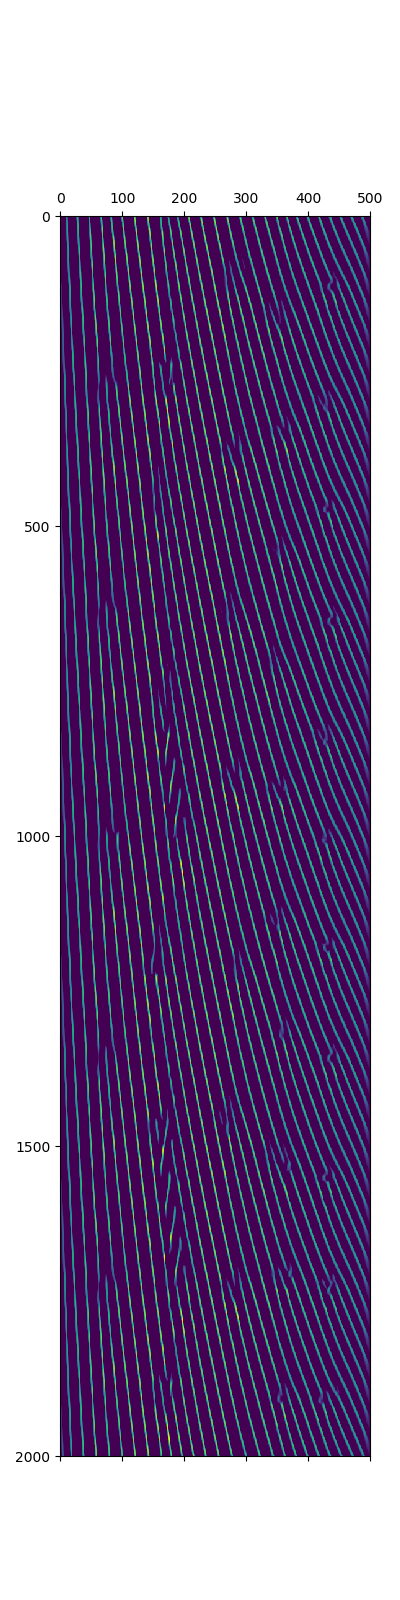

In [274]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN.simulate(500, logFreq=int(0.05/inhibGCN.dt), startFrom = 0.)

plt.matshow(instResults[-2000:, :])
plt.show()

In [233]:
inhibGCN.symmetrizer = torch.tensor(np.eye(1+2*inhibGCN.inhibitionWindow), device=device, dtype=torch.float)

In [296]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(20):
    print(i)
    inhibGCN.staticLearning(200, logFreq=100000, startFrom = 100.)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [216]:
update = inhibGCN.inhibitoryUpdate()
for i in range(9999):
    inhibGCN.step()
    update += inhibGCN.inhibitoryUpdate()
plt.matshow(update[0]/10000.)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


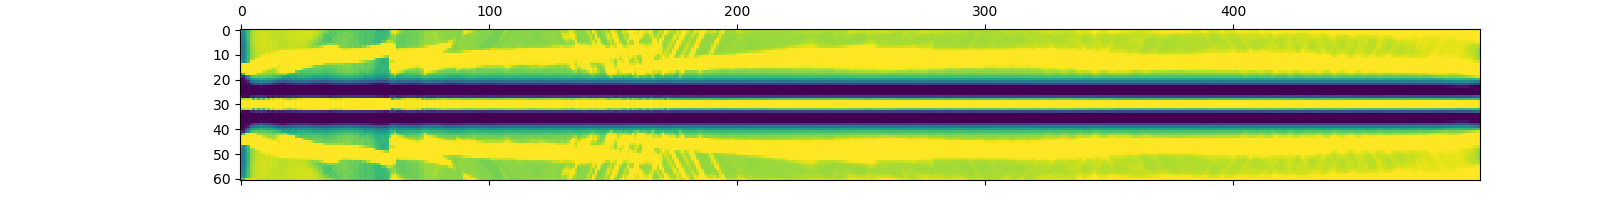

<IPython.core.display.Javascript object>


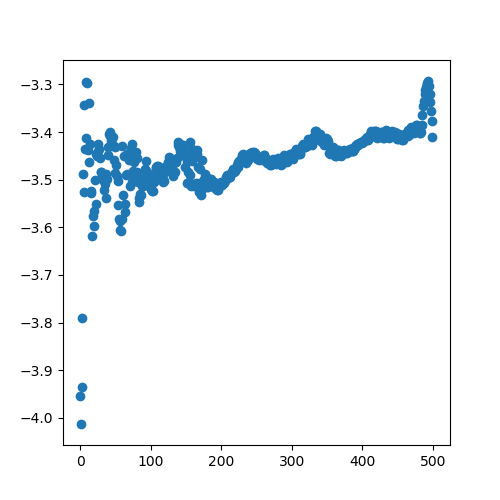

<IPython.core.display.Javascript object>


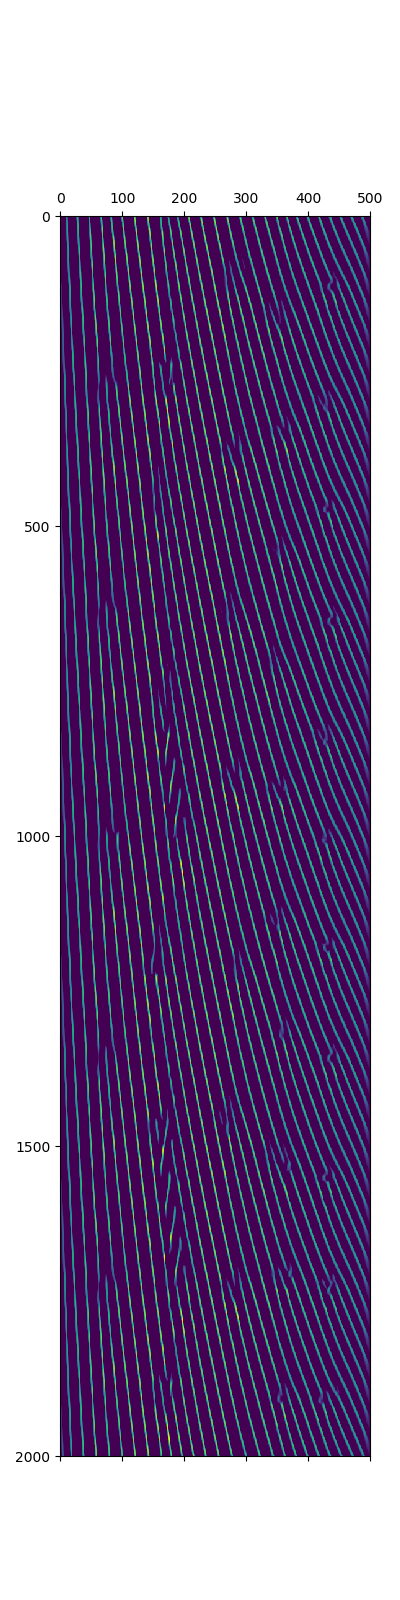

In [275]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN.numX),
            torch.mean(inhibGCN.inhibitoryWeights[0, 20:30], dim=0))
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(instResults[-2000:, :])
plt.show()

<IPython.core.display.Javascript object>


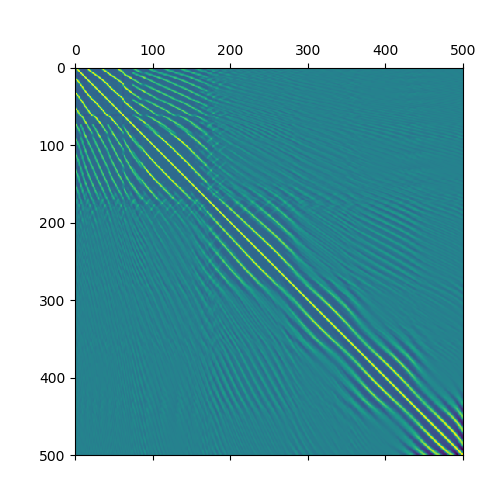

In [276]:
corrs = np.corrcoef(instResults[-2000:], rowvar=False)
plt.matshow(corrs)

<IPython.core.display.Javascript object>


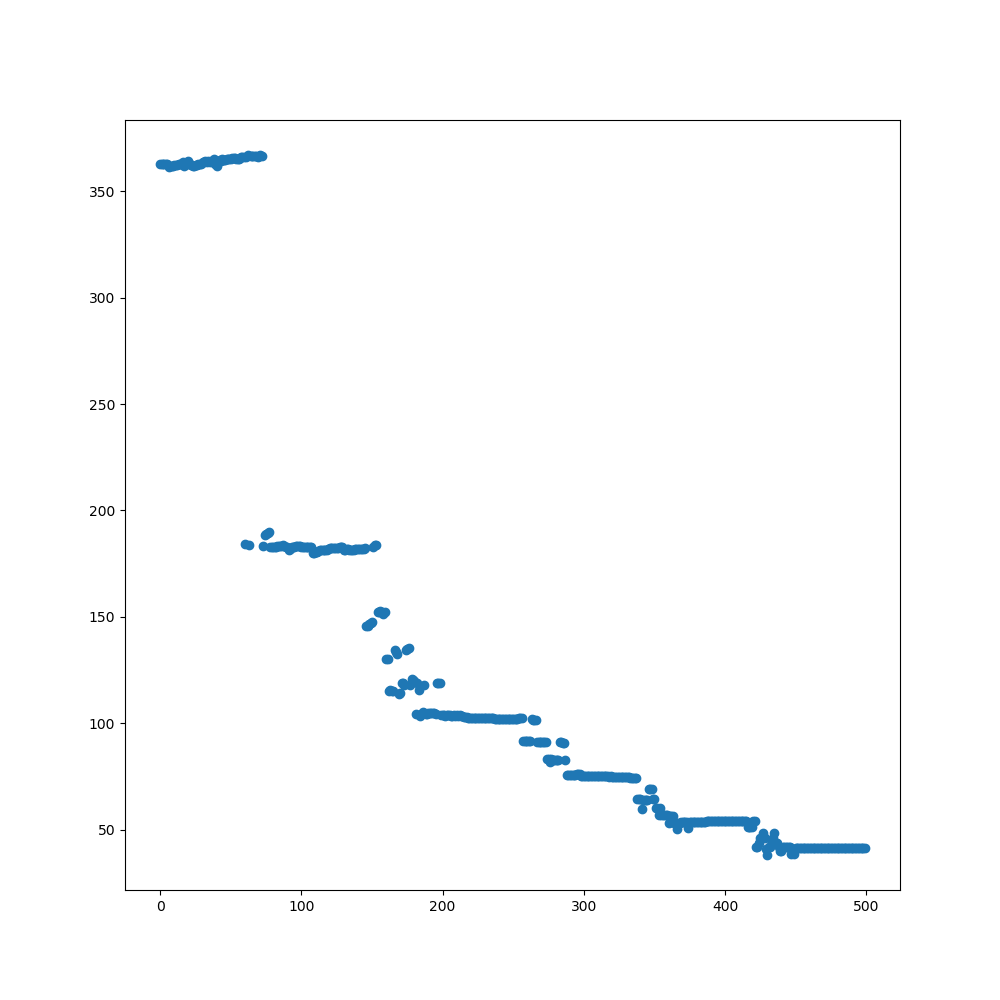

In [277]:
plt.rcParams['figure.figsize'] = [10, 10]
activityScales = compute_scales(instResults[-1000:, :]/np.max(instResults[-1000:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.show()

<IPython.core.display.Javascript object>


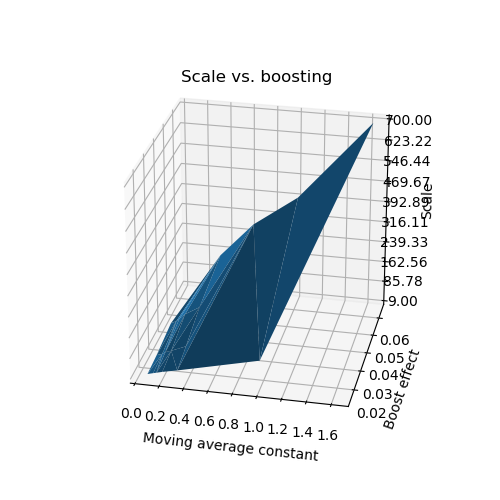

In [397]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()

<IPython.core.display.Javascript object>


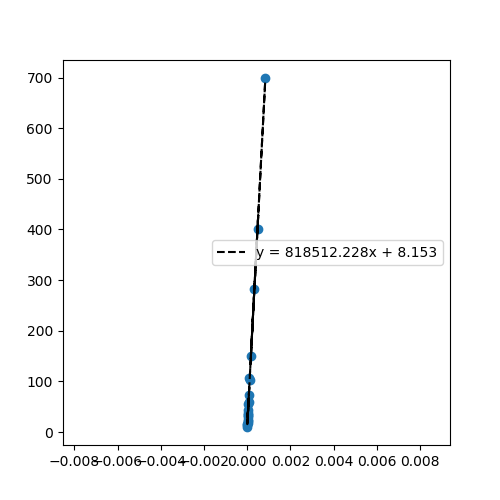

In [456]:
combinations = (1./(alphas/0.001) * 1./boostEffects)**0.7

plt.figure()
fit = np.polyfit(combinations,scales,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.scatter(combinations, scales)
plt.plot(combinations, fit_fn(combinations), '--k',
         label = "y = {0:4.3f}x + {1:4.3f}".format(fit_fn[1], fit_fn[0]))
plt.legend(loc="best")
plt.show()

In [283]:
inhibGCN.learnFactorP /= 10

In [284]:
results = inhibGCN.learn(20,
                          plotting=False,
                          logFreq=(0.05/inhibGCN2.dt),
                          speed=0.1,)

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4
Starting run 5
Starting run 6
Starting run 7
Starting run 8
Starting run 9
Starting run 10
Starting run 11
Starting run 12
Starting run 13
Starting run 14
Starting run 15
Starting run 16
Starting run 17
Starting run 18
Starting run 19


<IPython.core.display.Javascript object>


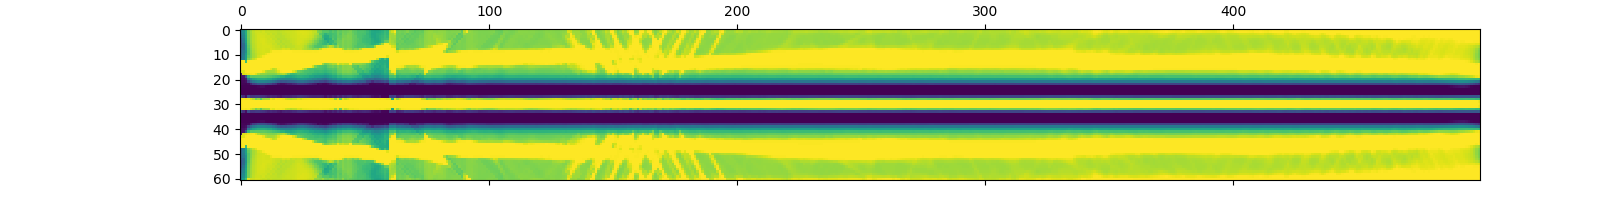

<IPython.core.display.Javascript object>


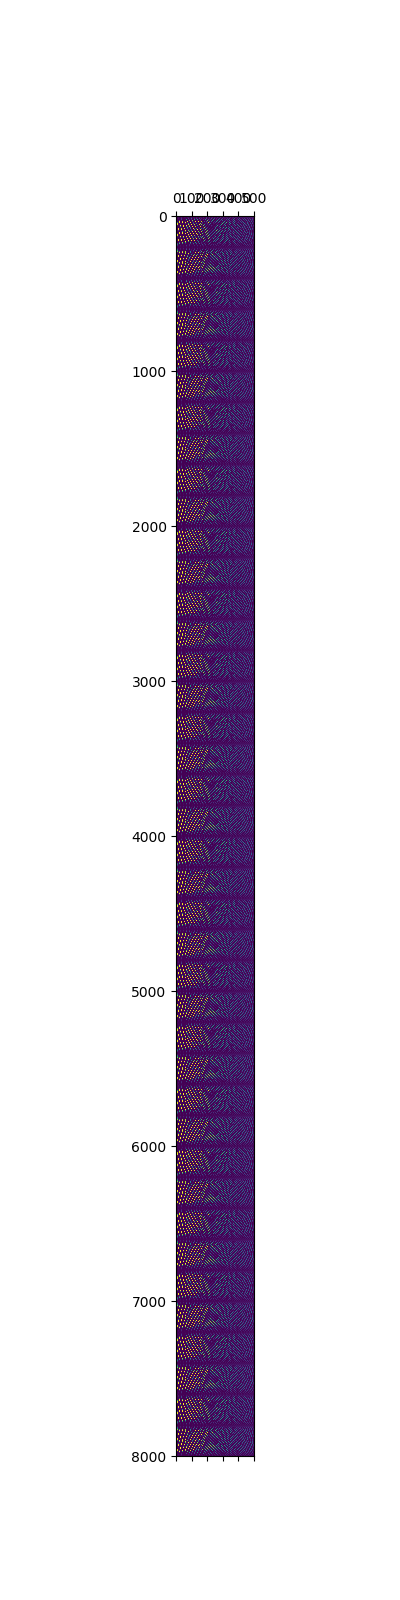

<IPython.core.display.Javascript object>


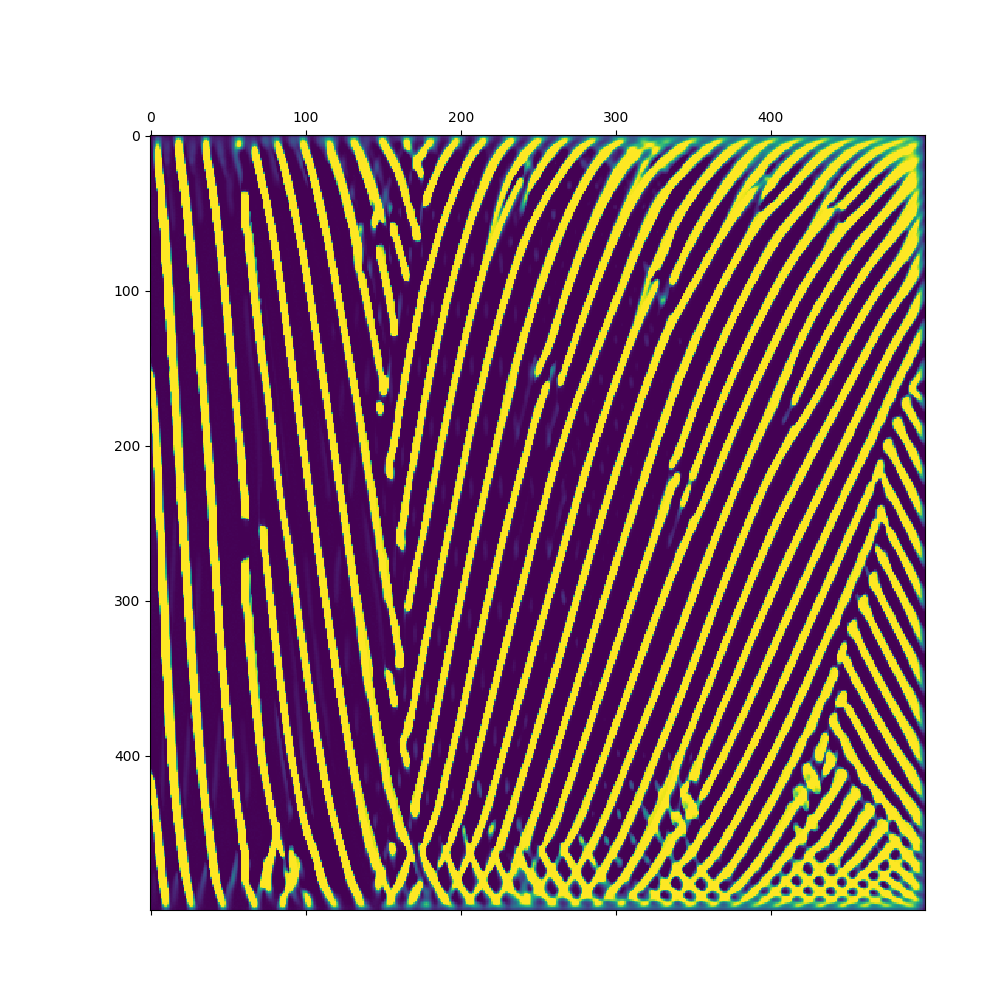

In [285]:
plt.matshow(inhibGCN.inhibitoryWeights[0])
plt.matshow(results, vmax = 1, vmin=0)
plt.matshow(torch.transpose(inhibGCN.placeWeights, 0, 1))

In [1670]:
plt.rcParams['figure.figsize'] = [5, 15]
hatGCN.learningRate = 5000
for i in range(20):
    print(i, hatGCN.learningRate)
    hatGCN.learn(1, plotting=False, plotInterval=10)
    weights = hatGCN.placeWeights.cpu().numpy()
    with open("PlaceWeights{}.npz".format(i), "wb") as f:
        np.savez(f, weights)
    hatGCN.learningRate/=1.05

0 5000
Starting run 0
1 4761.9047619047615
Starting run 0


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


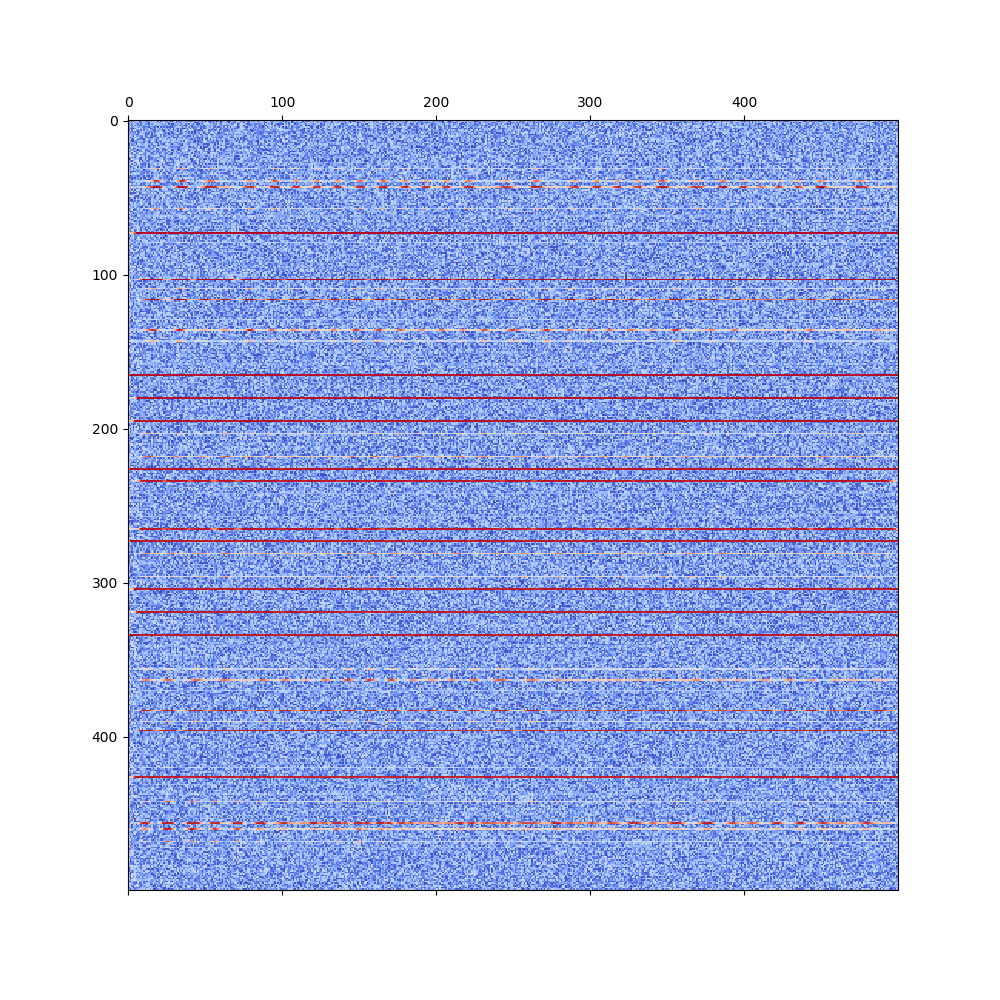

In [1672]:
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = plt.gca()
ax.matshow(torch.transpose(hatGCN.placeWeights, 0, 1).cpu().numpy()[:,],
                    cmap = plt.get_cmap("coolwarm"))
plt.show()

<IPython.core.display.Javascript object>


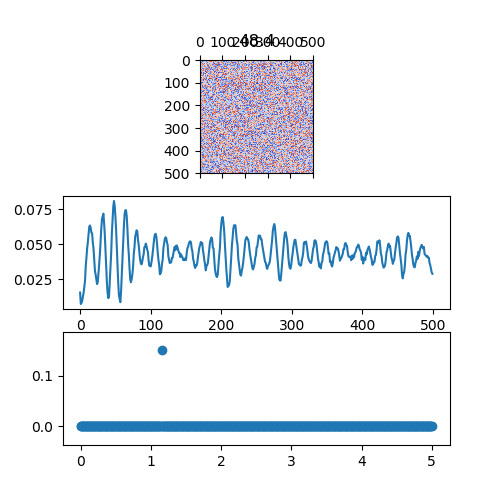

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4


KeyboardInterrupt: 

In [1675]:
plt.rcParams['figure.figsize'] = [5, 5]
hatGCN.learn(5000, plotting=True, plotInterval=10)

<IPython.core.display.Javascript object>


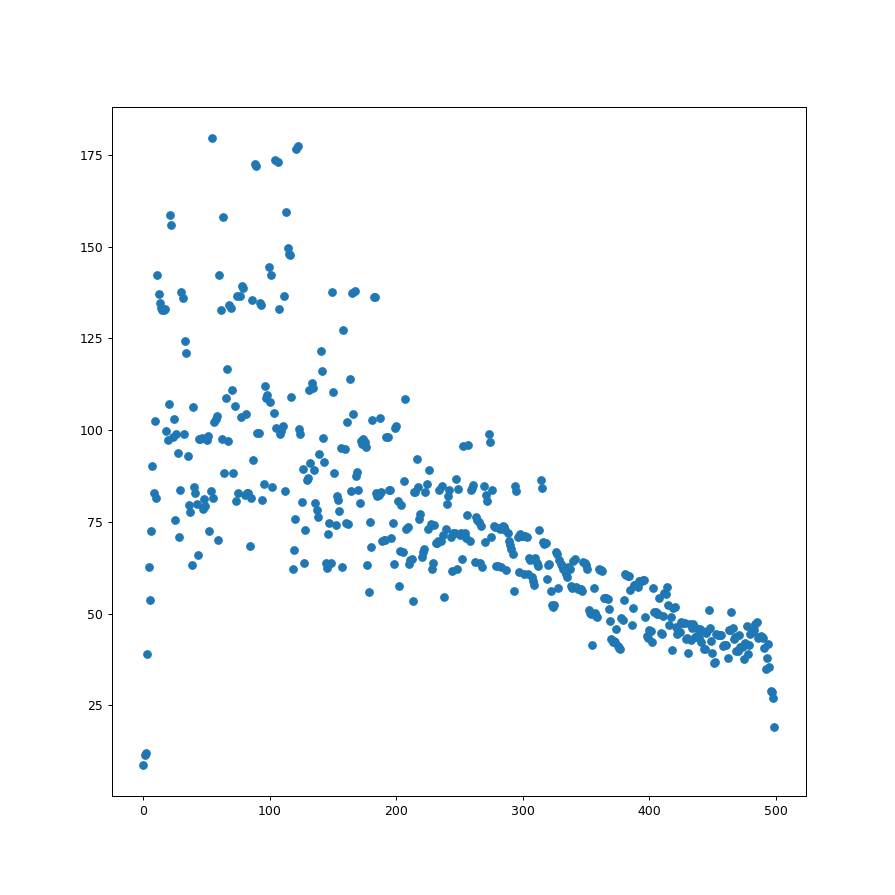

In [1007]:
weights = torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()
placeScales = compute_scales(weights[:, :]/np.max(weights[:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(placeScales.shape[0]), placeScales)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

<IPython.core.display.Javascript object>


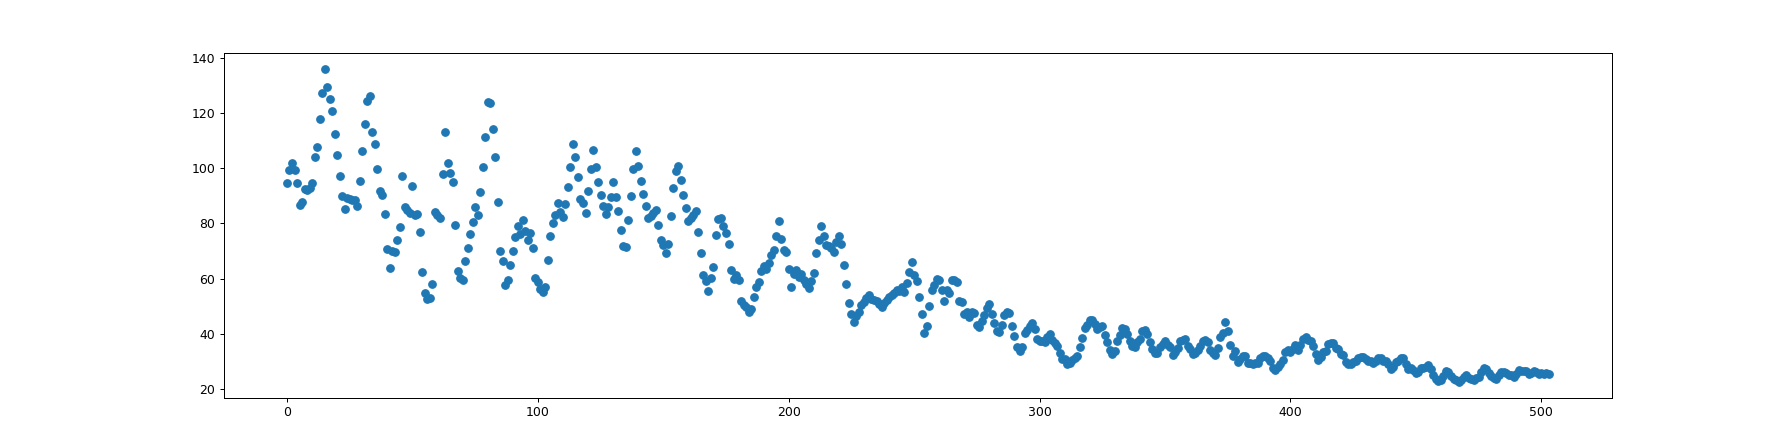

In [969]:
fig = plt.figure()
ax = plt.gca()
smoothed = smooth(placeScales,window_len=5, window="flat")
ax.scatter(np.arange(smoothed.shape[0]), smoothed)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Scales')
ax1.set_ylabel('Scale (cm)', color=color)
ax1.scatter(np.arange(GCN.numX), 1./placeScales, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Boost effect (negative square root)', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.arange(GCN.numX), np.power(GCN.boostEffect, 1/2.), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
np.min(results)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />